In [5]:
import os
os.chdir('../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect
from numpy.fft import fft
from numpy.fft import fftshift

Current Directory: c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification


In [6]:
class LogScaler:
    #Log normalization and data scaling
    
    def __init__(self):
        self._min0 = None
        self._max = None
        pass

    def fit(self, X, y=None):
        self._min0 = X.min(axis=0)
        self._max = np.log(X + np.abs(self._min0) + 1).max()

    def fit_transform(self, X, y=None):
        self._min0 = X.min(axis=0)
        X_norm = np.log(X + np.abs(self._min0) + 1)
        self._max = X_norm.max()
        return X_norm / self._max

    def transform(self, X, y=None):
        X_norm = np.log(X + np.abs(self._min0) + 1).clip(0, None)
        return (X_norm / self._max).clip(0, 1)


class FftTransformer:
    # Image transformer based on fast fourier transform

    def __init__(self, pixels=124):
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        self._xrot = None

    def fft_fit(self,X):     
        z1_lst=[]
        z2_lst=[]

        for cur_x in range(len(X)):
            x_ft = fftshift(fft(X[cur_x]))
                 
            real_lst =[0]*len(x_ft)
            imag_lst= [0]*len(x_ft)

            for i in range(len(x_ft)):
                real_lst[i] = x_ft[i].real
                imag_lst[i] = x_ft[i].imag

            q1, q3 = np.percentile(sorted(real_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(real_lst)):
                if real_lst[i] <= lower_bound or real_lst[i] >= upper_bound:
                    outliers.append(real_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                real_lst[outliers_idx[i]]=0
            
            # imag 
            q1, q3 = np.percentile(sorted(imag_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(imag_lst)):
                if imag_lst[i] <= lower_bound or imag_lst[i] >= upper_bound:
                    outliers.append(imag_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                imag_lst[outliers_idx[i]]=0

            z1_lst.append(np.array(real_lst))
            z2_lst.append(np.array(imag_lst))
    
        z1_lst = np.mean(np.array(z1_lst),axis=0) 
        z2_lst = np.mean(np.array(z2_lst),axis=0)

        real_mt = np.empty(shape=(x_ft.shape[0],1))
        real_mt.fill(0)
        imag_mt = np.empty(shape=(x_ft.shape[0],1))
        imag_mt.fill(0)

        for i in range(len(x_ft)):
            cur_real = z1_lst[i]
            real_mt[i] = cur_real

            cur_imag = z2_lst[i]
            imag_mt[i] = cur_imag

        z1 = real_mt
        z2 = imag_mt
        full_mt = np.hstack((z1,z2))
    
        return full_mt

    def fit(self, X, y=None, plot=False):
        x_new = self.fft_fit(X)        

        # get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices

        hull_points = x_new[chvertices]

        # get minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)
        
        # matrix rotation
        self._xrot = np.dot(mbr_rot, x_new.T).T
        
        # get feature coordinates from pixel dimension
        self._calculate_coords()

        #  rotation diagram plot
        if plot is True:
            plt.scatter(x_new[:, 0], x_new[:, 1], s=1,
                        cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
            plt.fill(x_new[chvertices, 0], x_new[chvertices, 1],
                     edgecolor='r', fill=False)
            plt.fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        # Image matrix dimensions
        # Returns:
        #     tuples: (height, width)

        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        # set image matrix dimension

        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):

        # Calculate matrix coordinates of each feature based on the pixel dimensions


        cur_xrp = self._xrot[:, 0]
        cur_yrp = self._xrot[:, 1] 

        ax0_coord = np.digitize(
            cur_xrp,
            bins=np.linspace(min(cur_xrp), max(cur_xrp),
                             self._pixels[0])
        ) - 1
        ax1_coord = np.digitize(
            cur_yrp,
            bins=np.linspace(min(cur_yrp), max(cur_yrp),
                             self._pixels[1])
        ) - 1

        self._coords = np.stack((ax0_coord, ax1_coord), axis=1)

    def transform(self, X):
 
        img_coords = pd.DataFrame(np.vstack((
            self._coords.T,
            X
        )).T).groupby([0, 1], as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

    
        img_matrices = np.array([self._mat_to_rgb(m) for m in img_matrices])
        
        return img_matrices

    def fit_transform(self, X, **kwargs):

        self.fit(X)
        return self.transform(X, **kwargs)

    def feature_density_matrix(self):

        fdmat = np.zeros(self._pixels)
        np.add.at(fdmat, tuple(self._coords.T), 1)
        return fdmat

    def coords(self):
        #Get feature coordinates

        return self._coords.copy()

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.
        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.
        Args:
            hull_points : an nx2 matrix of hull coordinates
        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2
        # calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)
        # find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            -np.sin(angles),
            np.sin(angles),
            np.cos(angles)]).T
        rotations = rotations.reshape((-1, 2, 2))
        # apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)
        # find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)
        # find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)
        # return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]
        # generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

    @staticmethod
    def _mat_to_rgb(mat):
        """Convert image matrix to numpy rgb format
        Args:
            mat: {array-like} (M, N)
        Returns:
            An numpy.ndarry (M, N, 3) with orignal values repeated across
            RGB channels.
        """
        return np.repeat(mat[:, :, np.newaxis], 3, axis=2)

In [7]:
import pandas as pd
import csv 
import numpy as np 
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [8]:
expr_file = r"./data/TCGA/curatedTCGAData_RNASeq2GeneNorm.txt"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)
unique_classes = np.unique(y, return_counts=True)

C:\Users\Darren Chong\AppData\Local\Temp\ipykernel_32360\639242102.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
C:\Users\Darren Chong\AppData\Local\Temp\ipykernel_32360\639242102.py:125: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


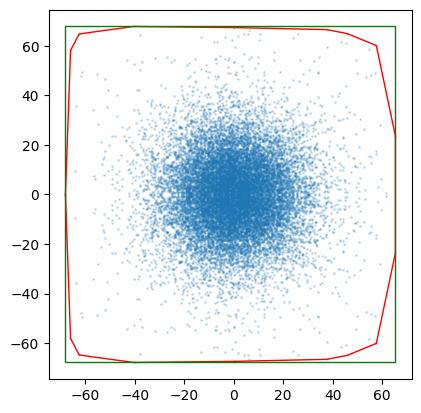

In [9]:
ln = LogScaler()

x_train_norm = ln.fit_transform(X_train)
x_test_norm = ln.transform(X_test)

it = FftTransformer(pixels=124)
_ = it.fit(x_train_norm, plot=True)

In [10]:
x_train_img = it.transform(x_train_norm)
x_train_img.shape

(3343, 124, 124, 3)

In [11]:
x_test_img = it.transform(x_test_norm)
x_test_img.shape

(836, 124, 124, 3)

Train img
BRCA
LGG
HNSC
THCA
LUSC
LUAD
BRCA
LGG
LGG
BRCA


<Figure size 1500x400 with 0 Axes>

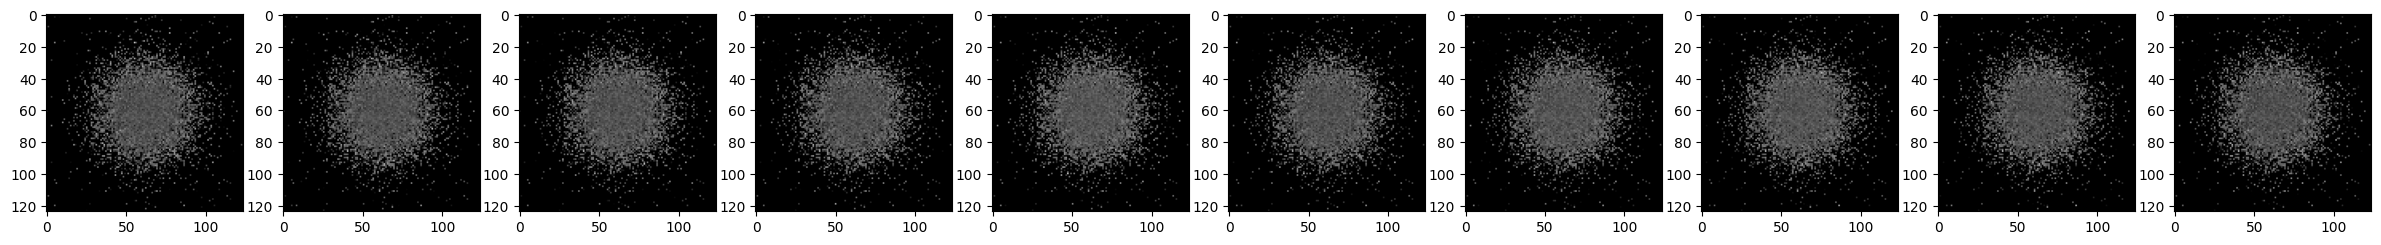

In [12]:
print("Train img")
plt.figure(figsize=(15,4))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):
    axarr[i].imshow(x_train_img[i])
    print(y_train[i])

Test img
BRCA
LGG
HNSC
THCA
LUSC
LUAD
BRCA
LGG
LGG
BRCA


<Figure size 1500x400 with 0 Axes>

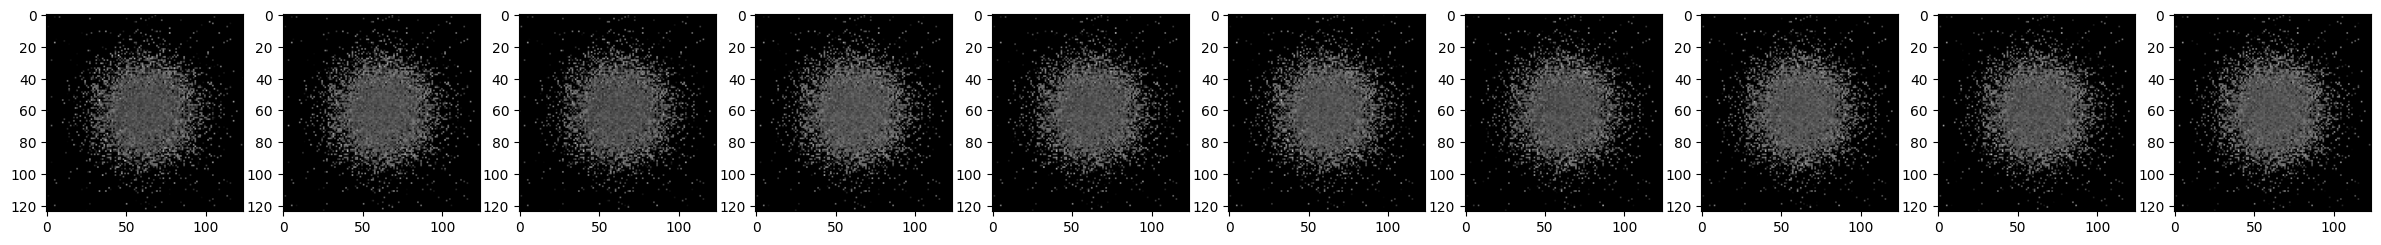

In [13]:
print("Test img")
plt.figure(figsize=(15,4))
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):   
    axarr[i].imshow(x_test_img[i])
    print(y_train[i])


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras import layers
import numpy as np

In [15]:
label = unique_classes[0].tolist()


n_lst=[]
for i in range(len(y_train)):
  for j in range(len(label)):
    if y_train[i] == label[j]:

      n_lst.append(j)

y_new_train = np.array(n_lst,dtype='float64')

n_lst=[]
for i in range(len(y_test)):
  for j in range(len(label)):
    if y_test[i] == label[j]:
      n_lst.append(j)

y_new_test = np.array(n_lst,dtype='float64')

In [16]:
df_y_train = to_categorical(y_new_train,num_classes=len(label))


In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau


model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=(124,124,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3) ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(len(label)))
model.add(Activation('sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, min_delta=1e-4, mode='auto')

model.fit(x_train_img, df_y_train, batch_size=32, epochs=90, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.2)




Epoch 1/90


84/84 [==============================] - 10s 114ms/step - loss: 1.8511 - accuracy: 0.3500 - val_loss: 1.0073 - val_accuracy: 0.7414 - lr: 0.0010
Epoch 2/90
 1/84 [..............................] - ETA: 8s - loss: 0.8082 - accuracy: 0.8750

C:\Users\Darren Chong\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - 9s 112ms/step - loss: 0.4098 - accuracy: 0.8837 - val_loss: 0.2502 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 3/90
84/84 [==============================] - 9s 108ms/step - loss: 0.1653 - accuracy: 0.9450 - val_loss: 0.1403 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 4/90
84/84 [==============================] - 10s 115ms/step - loss: 0.1224 - accuracy: 0.9600 - val_loss: 0.1118 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 5/90
84/84 [==============================] - 10s 114ms/step - loss: 0.0964 - accuracy: 0.9682 - val_loss: 0.0967 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 6/90
84/84 [==============================] - 9s 108ms/step - loss: 0.0750 - accuracy: 0.9783 - val_loss: 0.0977 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 7/90
84/84 [==============================] - 9s 107ms/step - loss: 0.0663 - accuracy: 0.9783 - val_loss: 0.0812 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 8/90
84/84 [==============================] - 9s 106ms/step - loss: 0.047

In [18]:
df_y_test = to_categorical(y_new_test,num_classes=len(label))

val_loss, val_acc = model.evaluate(x_test_img,df_y_test)
print(val_loss, val_acc)

27/27 [==============================] - 1s 24ms/step - loss: 0.0400 - accuracy: 0.9856
0.04000497981905937 0.9856459498405457


105/105 [==============================] - 3s 24ms/step
Training Accuracy: 0.9937182171702064
Test Accuracy: 0.9856459330143541
Precision (Macro): 0.9854973883602788
Precision (Micro): 0.9856459330143541
Precision (Weighted): 0.985709548522432
Recall (Macro): 0.9839035322058765
Recall (Micro): 0.9856459330143541
Recall (Weighted): 0.9856459330143541
F1-score (Macro): 0.984596744074279
F1-score (Micro): 0.9856459330143541
F1-score (Weighted): 0.985586420705081
ROC-AUC (OvO, Macro): 0.9465104963522722
ROC-AUC (OvO, Weighted): 0.9523869895800804


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       219
         1.0       0.99      1.00      1.00       104
         2.0       1.00      0.98      0.99       107
         3.0       1.00      1.00      1.00       103
         4.0       0.95      0.98      0.97       103
         5.0       0.97      0.93      0.95       100
         6.0       1.00      1.00      1.00       100

    accuracy   

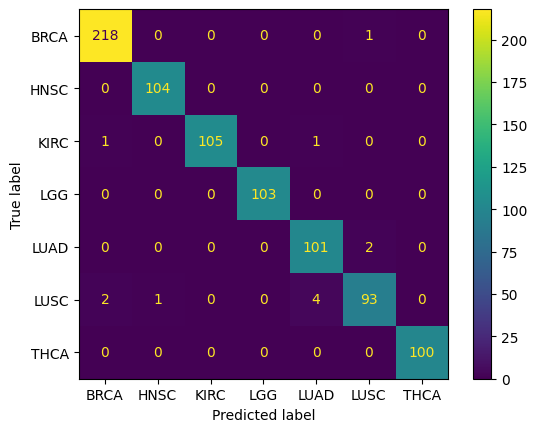

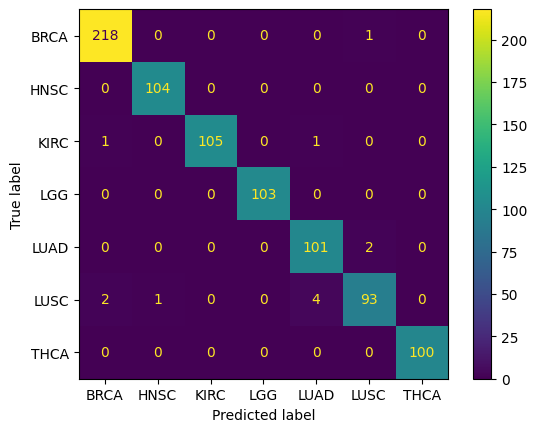

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

# Get predicted probabilities
y_pred_probs = model.predict(x_test_img)
y_pred_probs_normalized = y_pred_probs / np.sum(y_pred_probs, axis=1, keepdims=True)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate evaluation metrics
precision_macro = precision_score(y_new_test, y_pred, average='macro')
precision_micro = precision_score(y_new_test, y_pred, average='micro')
precision_weighted = precision_score(y_new_test, y_pred, average='weighted')
recall_macro = recall_score(y_new_test, y_pred, average='macro')
recall_micro = recall_score(y_new_test, y_pred, average='micro')
recall_weighted = recall_score(y_new_test, y_pred, average='weighted')
f1_macro = f1_score(y_new_test, y_pred, average='macro')
f1_micro = f1_score(y_new_test, y_pred, average='micro')
f1_weighted = f1_score(y_new_test, y_pred, average='weighted')

# For ROC AUC, we need to use the predicted probabilities
roc_auc_macro = roc_auc_score(y_new_test,y_pred_probs_normalized, average='macro', multi_class='ovo')
roc_auc_weighted = roc_auc_score(y_new_test, y_pred_probs_normalized, average='weighted', multi_class='ovo')

# Classification report (includes precision, recall, F1-score, support)
report = classification_report(y_new_test, y_pred)

# Calculate training accuracy
train_accuracy = accuracy_score(y_new_train, np.argmax(model.predict(x_train_img), axis=1))

# Calculate test accuracy
test_accuracy = accuracy_score(y_new_test, y_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_weighted)
print("\n")
print(report)

# Confusion matrix display
disp = ConfusionMatrixDisplay.from_predictions(y_new_test, y_pred, display_labels=label)
disp.plot()
